In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from HMC_Tools import EvaluateHMC

### 1. HMC sampler

In [2]:
class standard_hmc:
    def __init__(self, q0):
        self.q0 = q0

        self.Nq = len(q0)
        self.massinv = np.eye(self.Nq)
        self.MAX_SAMPLES = 10000

    def logp(self, x):
        return -0.5 * np.sum(x**2)

    def grad(self, x):
        return -x

    def target_density(self, x):
        x = np.array(x)
        return np.exp(-0.5 * np.sum(x**2))


    def create_p(self):
        p = np.random.normal(loc=0, scale=1.0, size=self.Nq) 
        return p
    
    def Kp(self, p):
        '''Compute Kp, as M is identical matrix. '''
        return  0.5 * p.T @ (self.massinv @p) 
    
    def leapfrog(self, q, p, e, L):

        for _ in range(L):  
            p = p + 1/2 * e * self.grad(q)
            q = q + e * self.massinv @ p
            p = p + 1/2 * e * self.grad(q)
        return q, p
    
    def sampling(self, e, L, Msamples, Madapt):

        q = self.q0

        samples = []
        for m in range(self.MAX_SAMPLES):
            if len(samples) >= Msamples + Madapt:
                break
    
            # update q and p
            p = self.create_p()
            current_q = q
            current_p = p
            new_q, new_p = self.leapfrog(current_q, current_p, e, L)
            #print(current_q, new_q)
            # calculate Hamiltonian from potential energy and kinetic energy
            current_U = -self.logp(current_q)
            current_K = self.Kp(current_p)
    
            new_U = --self.logp(new_q)
            new_K = self.Kp(new_p)
    
            # determine whether accept the proposed sample or not
            denergy = current_U - new_U + current_K - new_K
            acceptance_prob = min(0, denergy)
            alpha = np.log(np.random.rand())
        
            if alpha < acceptance_prob:
                q = new_q
                samples.append(q)
            else:
                q = current_q
    
        print('Acceptance_rate = {}'.format(len(samples)/m))
        return np.array(samples)[Madapt:]
    

# Initialization

For each method, we drew 5000 sample safter 1000 burn-in samples.

In [4]:
Nq = 1000
q0 = np.random.normal(0, 1, Nq)

# tunning hyperparameters: step size, the number of steps, mass matrix
epsilon = 0.05
L = 20
Msamples = 5000
Madapt = 1000

print("==============Start Sampling=============")
t_start = time.time()
hmc = standard_hmc(q0)
samples = hmc.sampling(epsilon, L, Msamples, Madapt)

t_stop = time.time()
print("Sampling Completed in %0.2f seconds" % (t_stop - t_start))
time_cost = t_stop - t_start


==============Start Sampling=============
Acceptance_rate = 1.0
Sampling Completed in 119.46 seconds


#### Convergency speed

1. ACF(Autocorrelation Function) 自相关函数是一个用于评估样本独立性和质量的一个重要工具：\
如果ACF快速下降到零，说明样本之间的独立性较高；
反之，样本之间存在较高的自相关性，样本独立性较低。
2. ACF 可以用来计算有效样本大小（Effective Samples Size, ESS)，其计算公式为 $ESS = M/\tau$，其中M是总样本数，$\tau$是集成自相关时间（integrated autocorrelation time），其定义为: \
   $\tau = 1+2*\sum_{k=1}^{M_{cutoff}} (1- \frac{s}{M}) \rho_k$; $M_{cutoff} = min s$, $s.t. \rho < 0.05$ \
   $\rho = \frac{1}{\sigma^2 (M-s)} \sum_{m=s+1}^{M}(f(\theta^m)-\mu)(f(\theta^{m-s})-\mu)$
   where $\sigma^2$ is the mean of f and $\mu$ is the variance of f

<Figure size 1000x1000 with 0 Axes>

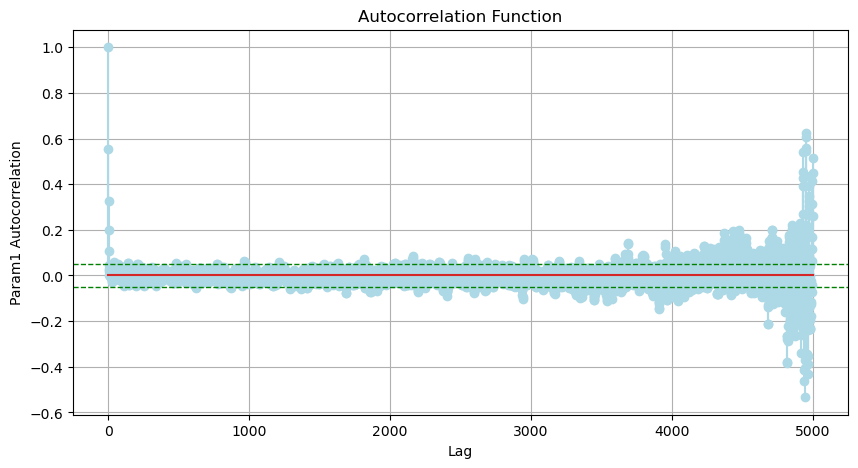

Effective Sample Size (ESS): 53.77287739031939
Time per Effective Sample Size (ESS):2.2215541678595034 second


In [7]:
max_lag=5000
data = samples[:,1]

hmc_tool = EvaluateHMC(data)
ESS = hmc_tool.effective_sample_size(max_lag)
hmc_tool.plot_autocorrelation(max_lag, label='Param1')
print("Effective Sample Size (ESS):", ESS)


TES = time_cost/ESS
print("Time per Effective Sample Size (ESS):{} second".format(TES))

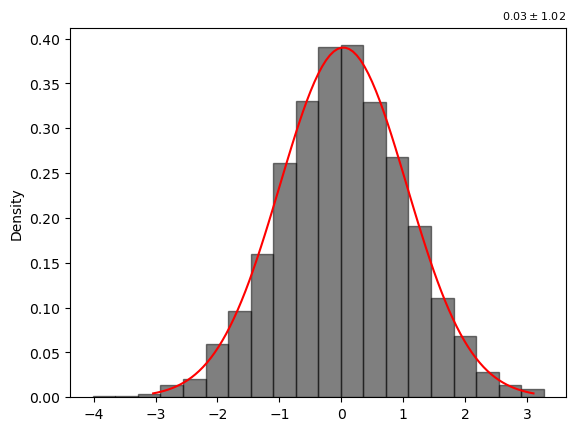

In [8]:
from scipy.stats import norm
mu, sigma = np.mean(data), np.std(data)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
gaussian = norm.pdf(x, mu, sigma)
plt.plot(x, gaussian, color='red', label='Gaussian Distribution')
plt.hist(data, bins=20,color='k',edgecolor='k',alpha=0.5,density=True)
plt.title(f'${mu:.2f} \pm {sigma:.2f}$', fontsize=8, loc='right')
plt.ylabel('Density')
plt.show()
